In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from common import ExperimentManifest, ExperimentRun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_ber(a: bytes, b: bytes):
    if not isinstance(a, bytes) or not isinstance(b, bytes):
        return np.nan

    tx_bits = np.unpackbits(np.frombuffer(a, dtype=np.uint8))
    rx_bits = np.unpackbits(np.frombuffer(b, dtype=np.uint8))
    return np.mean(tx_bits != rx_bits)

def get_ber_df(df: pd.DataFrame):
    return df[["tx_payload", "rx_payload"]].apply(lambda x: get_ber(x.tx_payload, x.rx_payload), axis=1)

def plot_df_ber_frame_loss(df: pd.DataFrame):
    ax = df.plot.scatter(x="tx_baudrate", y="ber", alpha=0.4, figsize=(8, 5))
    ax.set_yscale("symlog", linthresh=1e-4)
    ax.set_ylim((0, 1))
    ax.set_ylabel("Bit error rate")
    ax.set_xlabel("Baud rate [Bd]")
    ax.set_xticks(df.tx_baudrate.unique())
    # ax.set_title("Bit error rate and frame loss rate vs. baud rate at 1m")
    ax.legend(["Bit error rate"], loc="upper left")
    ax2 = ax.twinx()
    df.groupby("tx_baudrate").agg({"ber": lambda x: x.isna().mean()}).plot(ax=ax2, color="red")
    ax2.set_ylabel("Frame loss rate")
    ax2.set_ylim((0.0, 1.19))
    ax2.legend(["Frame loss rate"])
    return ax

# BER and frame loss

In [19]:
# dbpsk_redo_3 is ok for 5350 hz


In [20]:
df.tx_modulation.unique()

NameError: name 'df' is not defined

## FSK

In [21]:
manifest_fsk = ExperimentManifest.load("exp/archive/ex_full_v5")
df_fsk = pd.DataFrame(manifest_fsk.runs)
# df
df_fsk = df_fsk.loc[
    df_fsk.rx_ok & (df_fsk.tx_modulation == "fsk") & (df_fsk.tx_modulation_freqs==(14850.0, 15680.0))
    & df_fsk.tx_baudrate.isin([50, 100, 200, 300, 400])
]
df_fsk["ber"] = get_ber_df(df_fsk)

pd.set_option('display.max_rows', 500)
df_fsk.groupby([ "tx_modulation_freqs", "distance_m", "tx_baudrate"]).agg({"ber": [("ber", lambda x: x.mean(skipna=True)), ("frame_loss", lambda x: x.isna().mean()), ("count", "count")]})

ber                 
                                                 ber frame_loss count
tx_modulation_freqs distance_m tx_baudrate                           
(14850.0, 15680.0)  1.0        50           0.000684        0.0    20
                               100          0.000098        0.0    20
                               200          0.000391        0.0    20
                               300          0.004557        0.4    12
                               400               NaN        1.0     0
                    2.0        50           0.000195        0.0    20
                               100          0.000293        0.0    20
                               200          0.000488        0.0    20
                               300          0.000000        0.4    12
                               400          0.004883        0.9     2

### 1m

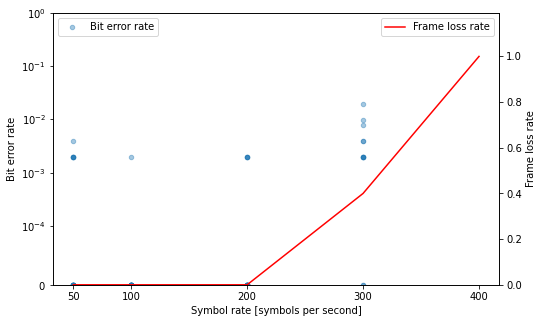

In [22]:
df_fsk_1m = df_fsk.loc[df_fsk.distance_m == 1.0]
plot_df_ber_frame_loss(df_fsk_1m)
plt.savefig("figures/fsk_ber_frameloss_1m.pdf")
plt.show()

### 2m

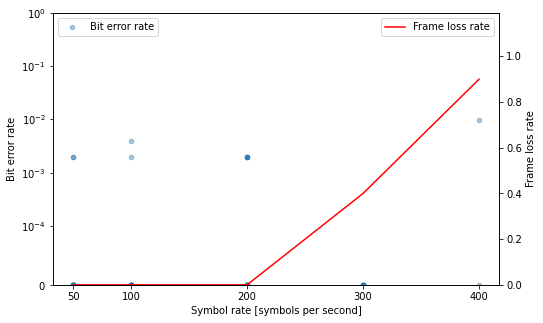

In [23]:
df_fsk_2m = df_fsk.loc[df_fsk.distance_m == 2.0]
plot_df_ber_frame_loss(df_fsk_2m)
plt.savefig("figures/fsk_ber_frameloss_2m.pdf")
plt.show()

### List of lost frames

In [31]:
df_fsk.loc[df_fsk.rx_ok & df_fsk.rx_payload.isna()][["uuid", "tx_modulation_freqs", "tx_baudrate", "distance_m"]]

,uuid,tx_modulation_freqs,tx_baudrate,distance_m


### Frame loss (empty frames)

In [87]:
manifest_e = ExperimentManifest.load("ex_empty")
df_e = pd.DataFrame(manifest_e.runs)
df_e = df_e.loc[df_e.rx_ok]

In [88]:
df_e.groupby("tx_modulation_freqs").agg({"rx_frame_count": "mean"})

,rx_frame_count
tx_modulation_freqs,
"(4700.0, 5240.0)",10.000
"(8370.0, 8730.0, 9125.0, 9680.0)",4.000
"(11430.0, 12630.0)",9.925
"(14850.0, 15680.0)",9.500


In [89]:
df_e.loc[df_e.rx_frame_count <= 5][["uuid", "tx_modulation_freqs", "tx_baudrate", "distance_m", "rx_frame_count"]]

,uuid,tx_modulation_freqs,tx_baudrate,distance_m,rx_frame_count
27,046f5e79-b43a-4045-9ea9-232642a7b37d,"(8370.0, 8730.0, 9125.0, 9680.0)",150,0.5,5
31,82869196-0a33-4cbd-95de-bfa7fe049c12,"(8370.0, 8730.0, 9125.0, 9680.0)",200,0.5,0
47,1b43ce8d-64fc-4d6a-b803-c4095648a3ef,"(8370.0, 8730.0, 9125.0, 9680.0)",200,0.5,2
55,ef4409d2-e7c5-401a-8207-297d61e92c41,"(8370.0, 8730.0, 9125.0, 9680.0)",100,0.5,5
59,f073c9a4-f0f9-4228-8280-7376dd92c87a,"(8370.0, 8730.0, 9125.0, 9680.0)",150,0.5,1
63,3b70ef40-81b2-466c-a07a-40b4a80e8629,"(8370.0, 8730.0, 9125.0, 9680.0)",200,0.5,0
71,f68a936e-e44f-4a7b-9075-4eaf75c3f186,"(8370.0, 8730.0, 9125.0, 9680.0)",100,0.5,5
75,74fc76ca-82c9-4e69-85df-18c68dfd456e,"(8370.0, 8730.0, 9125.0, 9680.0)",150,0.5,0
79,781307fa-9e79-4801-9ac4-14e294147f8a,"(8370.0, 8730.0, 9125.0, 9680.0)",200,0.5,0
82,2027acf9-2cba-4496-999d-1c00c8331305,"(14850.0, 15680.0)",50,0.5,4


## DBPSK

In [26]:
manifest_dbpsk = ExperimentManifest.load("exp/dbpsk_final")
df_dbpsk = pd.DataFrame(manifest_dbpsk.runs)
# df
df_dbpsk = df_dbpsk.loc[
    df_dbpsk.rx_ok & (df_dbpsk.tx_modulation == "dbpsk") 
]
df_dbpsk["ber"] = get_ber_df(df_dbpsk)

pd.set_option('display.max_rows', 500)
df_dbpsk.groupby([ "tx_modulation_freqs", "distance_m", "tx_baudrate"]).agg({"ber": [("ber", lambda x: x.mean(skipna=True)), ("frame_loss", lambda x: x.isna().mean()), ("count", "count")]})

ber                 
                                                 ber frame_loss count
tx_modulation_freqs distance_m tx_baudrate                           
(5330.0,)           1.0        50           0.000000       0.00    20
                               100          0.000000       0.00    20
                               200          0.000000       0.00    20
                               300          0.000000       0.15    17
                               400          0.022204       0.05    19
                               500          0.038462       0.35    13
                    2.0        50           0.171875       0.45    11
                               100          0.017188       0.25    15
                               200          0.089844       0.80     4
                               300          0.078125       0.95     1
                               400               NaN       1.00     0
                               500               NaN       1.00     0
(12473.0,)          1.0        50           0.005078       0.00    20
                               100          0.000000       0.00    20
                               200          0.000781       0.00    20
                               300          0.044118       0.15    17
                               400          0.046007       0.55     9
                               500          0.046875       0.90     2
                    2.0        50           0.035937       0.00    20
                               100          0.048109       0.05    19
                               200          0.050426       0.45    11
                               300          0.041233       0.10    18
                               400               NaN       1.00     0
                               500          0.115234       0.80     4

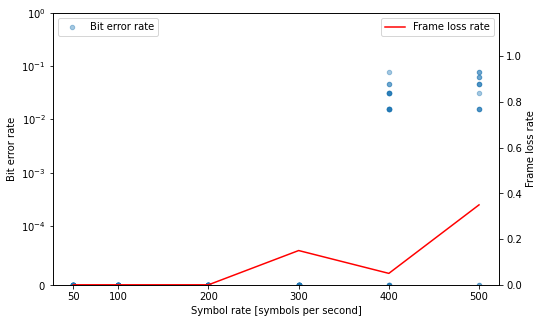

In [30]:
df_dbpsk_1m = df_dbpsk.loc[(df_dbpsk.distance_m == 1) & (df_dbpsk.tx_modulation_freqs == (5330.0,))]
plot_df_ber_frame_loss(df_dbpsk_1m)
plt.savefig("figures/dbpsk_ber_frameloss_1m.pdf")
plt.show()

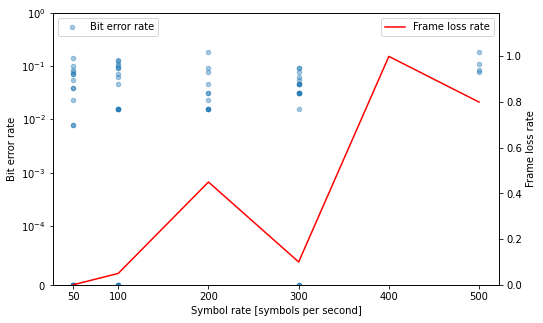

In [31]:
df_dbpsk_2m = df_dbpsk.loc[(df_dbpsk.distance_m == 2) & (df_dbpsk.tx_modulation_freqs == (12473.0,))]
plot_df_ber_frame_loss(df_dbpsk_2m)
plt.savefig("figures/dbpsk_ber_frameloss_2m.pdf")
plt.show()

### Lost frames

In [83]:
df_dbpsk.loc[df_dbpsk.rx_ok & df_dbpsk.rx_payload.isna()][["uuid", "tx_modulation_freqs", "tx_baudrate", "distance_m"]]

,uuid,tx_modulation_freqs,tx_baudrate,distance_m
9,c5e91910-0590-479f-bdaa-252059fbe350,"(12473.0,)",400,1.0
10,df43fe75-5920-4f99-942d-97d230d954a8,"(5330.0,)",500,1.0
11,550ef2ce-fec8-49f2-bba5-28e2e51a3422,"(12473.0,)",500,1.0
17,a43ef425-a632-4d8b-8be2-e2864226567c,"(12473.0,)",200,1.0
21,754a9380-20ac-453a-96db-d53d7a57b1bd,"(12473.0,)",400,1.0
22,36ba97f4-8dc3-42e1-b72c-38d6803e7716,"(5330.0,)",500,1.0
23,8871d369-77c1-4ac0-be68-af71dd015180,"(12473.0,)",500,1.0
30,4b6c5fdf-96b3-47af-b95e-244215b7032c,"(5330.0,)",300,1.0
31,0e74d793-fc44-42f3-a4b0-2a3a8daf3659,"(12473.0,)",300,1.0
34,fbe823f6-62c8-495c-8826-ef791ed55c3e,"(5330.0,)",500,1.0


# Chirp analysis

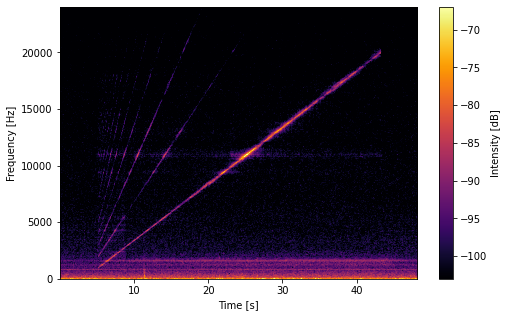

In [79]:
from scipy import signal
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

ex_chirp_name = "ex_chirp_1m"
manifest_chirp = ExperimentManifest.load(ex_chirp_name)
x, fs = sf.read(os.path.join(ex_chirp_name, manifest_chirp.get_run_by_uuid("0495e7de-4f58-47c5-9f4c-26909f2bcc22").base_filename + ".wav"))
# f, t, Sxx = signal.spectrogram(x, fs, nperseg=1024, scaling="spectrum")
plt.figure(1, figsize=(8, 5))
# im = plt.pcolormesh(t, f, Sxx, shading='gouraud', norm=colors.LogNorm(vmin=1e1, vmax=1e5), rasterized=True)
_, _, _, im = plt.specgram(x, NFFT=4096, Fs=fs, vmin=-103, vmax=-67, cmap="inferno")
plt.colorbar(im).set_label("Intensity [dB]")
# plt.ylim((10000.0, 15000.0))
# plt.xlim((1.0, 1.3))
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.savefig("figures/chirp_spectrogram.pdf", dpi=150)
plt.show()

## Frequency response

/tmp/ipykernel_221959/1043785297.py:9: RuntimeWarning: invalid value encountered in log10
  plt.plot(f, np.log10(Pxx_chirp - Pxx_noise) * 10)


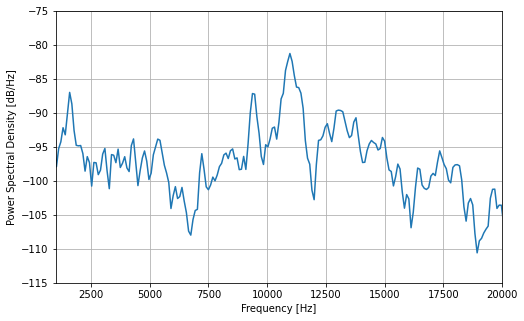

In [160]:
x_noise = x[:int(5 * fs)]
x_chirp_only = x[int(5.14 * fs):int(43.14*fs)]

f, Pxx_noise = signal.welch(x_noise, fs=fs, nperseg=512)
_, Pxx_chirp = signal.welch(x_chirp_only, fs=fs, nperseg=512)

plt.figure(1, figsize=(8, 5))
# plt.psd(x_chirp_only, NFFT=512, Fs=fs, label="withnoise")
plt.plot(f, np.log10(Pxx_chirp - Pxx_noise) * 10)
plt.grid(True)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density [dB/Hz]")
plt.xlim((1000, 20000))
plt.ylim((-115, -75))
# plt.legend()
plt.savefig("figures/frequency_response.pdf")
plt.show()

## Spectral leakage

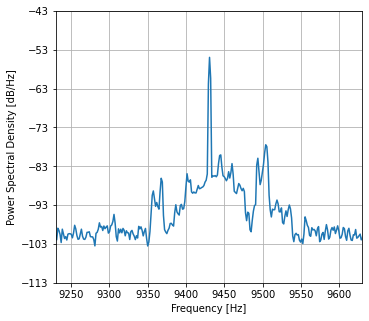

In [161]:
x_9430, fs = sf.read("tone/spectral_leakage/9khz.wav")

plt.figure(1, figsize=(5.5, 5))
plt.psd(x_9430[int(fs * 4.5):int(fs * 13)], NFFT=32768, Fs=fs)
plt.xlim((9230, 9630))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density [dB/Hz]")
plt.savefig("figures/spectral_leakage_9430hz.pdf")
plt.show()

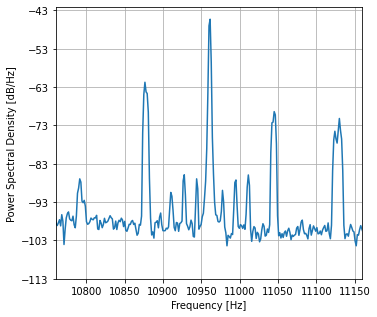

In [162]:
x_10960, fs = sf.read("tone/spectral_leakage/11khz.wav")
plt.figure(1, figsize=(5.5, 5))
plt.psd(x_10960[int(fs * 4.5):int(fs * 13)], NFFT=32768, Fs=fs)
plt.xlim((10760, 11160))
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power Spectral Density [dB/Hz]")
plt.savefig("figures/spectral_leakage_10960hz.pdf")
plt.show()

# CPU kernel difference

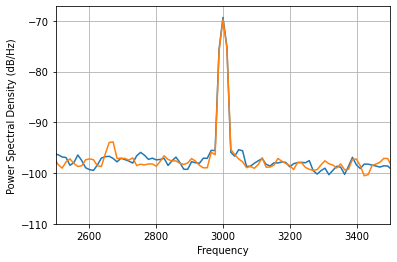

In [177]:
x_avx2, fs = sf.read("tone/kernel_diff/avx2_3khz.wav")
x_nop, fs = sf.read("tone/kernel_diff/nop_3khz.wav")
plt.psd(x_avx2[int(fs*5.0):int(fs*8.0)], Fs=fs, NFFT=4096)
plt.psd(x_nop[int(fs*5.0):int(fs*8.0)], Fs=fs, NFFT=4096)
plt.xlim((2500, 3500))
plt.show()

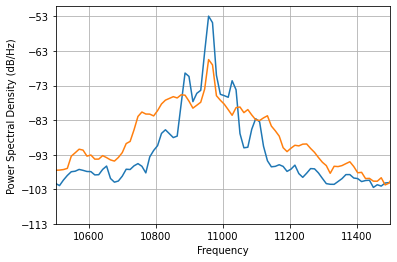

In [175]:
x_avx2, fs = sf.read("tone/kernel_diff/avx2_10960hz.wav")
x_nop, fs = sf.read("tone/kernel_diff/nop_10960hz.wav")
plt.psd(x_avx2[int(fs*7.0):int(fs*9.0)], Fs=fs, NFFT=4096)
plt.psd(x_nop[int(fs*7.0):int(fs*9.0)], Fs=fs, NFFT=4096)
plt.xlim((10500, 11500))
plt.show()

# FSK illustration

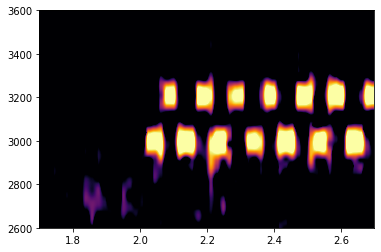

In [75]:
import soundfile as sf
import matplotlib.pyplot as plt
audio_filename = "/home/peter/20bps.wav"
samples, fs = sf.read(audio_filename)
plt.specgram(samples, NFFT=1024, Fs=fs, vmin=-80, vmax=-67, cmap="inferno", pad_to=8192)
plt.ylim((2600, 3600))
plt.xlim((1.7, 2.7))
plt.show()